<Figure size 640x480 with 0 Axes>

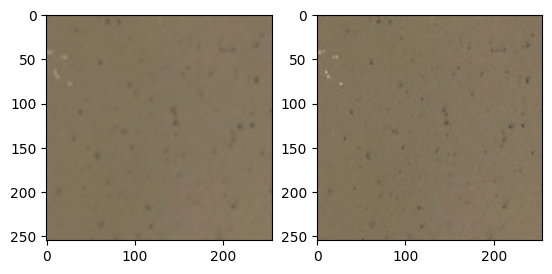

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from data import SRCNNDataset
import torch
import copy
import time
from model import SRCNN
from util import psnr
import torch.backends.cudnn as cudnn

data = np.load("../256dataset_images_small.npy")
data = np.transpose(data, (0, 2, 3, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure()
f, ax = plt.subplots(1, 2)

dataset = SRCNNDataset(hr_images=data, scale_factor=3)
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

lr, hr = next(iter(train_dataloader))

ax[0].imshow(lr[10].T)
ax[1].imshow(hr[10].T)



C:\Users\Andrew\AppData\Local\Temp\ipykernel_19288\2310598844.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_models/SRCNN_200

Epoch 1 / 1000
Training loss: 0.002000164685762107 | Validation loss: 0.0020330894139728374 | PSNR: 27.013545279140715 | Time: 71.42145490646362
Epoch 2 / 1000
Training loss: 0.001998759984378002 | Validation loss: 0.0020316825443712464 | PSNR: 27.01663370078784 | Time: 70.98833966255188
Epoch 3 / 1000
Training loss: 0.001997365413578294 | Validation loss: 0.00203028589229299 | PSNR: 27.019700572837724 | Time: 70.07393407821655
Epoch 4 / 1000
Training loss: 0.001995980677891299 | Validation loss: 0.0020288986432465857 | PSNR: 27.022749022496775 | Time: 70.34318161010742
Epoch 5 / 1000
Training loss: 0.00199460553572393 | Validation loss: 0.002027520275026161 | PSNR: 27.02577947541349 | Time: 70.40254640579224
Epoch 6 / 1000
Training loss: 0.001993239834254998 | Validation loss: 0.0020261517064812194 | PSNR: 27.028790125918192 | Time: 70.49644994735718
Epoch 7 / 1000
Training loss: 0.001991883404233733 | Validation loss: 0.0020247922204102257 | PSNR: 27.031782669843306 | Time: 71.209327

<Figure size 640x480 with 0 Axes>

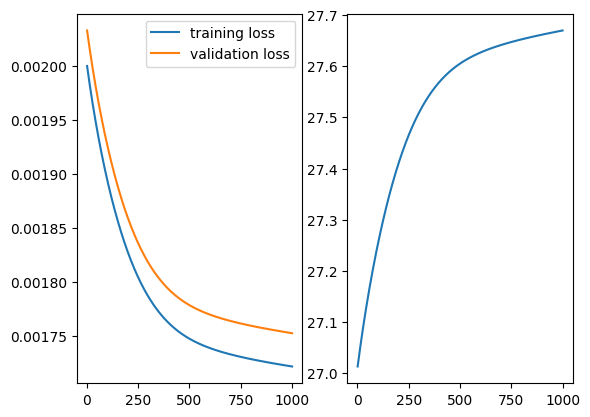

In [19]:
def train(model, train_set, validation_set, epochs, lr, model_name):
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.SGD([{'params': model.conv1.parameters()},
                                 {'params': model.conv2.parameters()},
                                 {'params': model.conv3.parameters(), lr: lr*0.1}], lr=lr)
    training_loss = []
    validation_loss = []
    psnrs = []
    
    cudnn.benchmark = True
    torch.cuda.empty_cache()

    best_weights = copy.deepcopy(model.state_dict())
    best_psnr = 0.0

    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch} / {epochs}")
        t0 = time.time()
        epoch_train_loss = 0
        for index, batch in enumerate(train_set):
            print(f"Batch {index} / {len(train_set)-1}", end="\r")
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            y_pred = model(features)
            loss = loss_function(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss+=loss.cpu().item()
        training_loss.append(epoch_train_loss/len(train_set))

        epoch_validation_loss = 0
        epoch_validation_psnr = 0
        with torch.no_grad():
            for index, batch in enumerate(validation_set):
                print(f"Validation Batch {index} / {len(validation_set)-1}", end="\r")
                features, labels = batch
                features = features.to(device)
                labels = labels.to(device)
                
                y_pred = model(features)
                loss = loss_function(y_pred, labels)

                epoch_validation_loss+=loss.cpu().item()
                epoch_validation_psnr+=psnr(y_pred, labels)
            validation_loss.append(epoch_validation_loss/len(validation_set))
            psnrs.append(epoch_validation_psnr/len(validation_set))

            if epoch_validation_psnr>best_psnr:
                best_psnr = epoch_validation_psnr
                best_weights = copy.deepcopy(model.state_dict())
            if epoch%100==0:
                torch.save(best_weights, f"trained_models/{model_name}")
        
        print(f"Training loss: {epoch_train_loss/len(train_set)} | Validation loss: {epoch_validation_loss/len(validation_set)} | PSNR: {epoch_validation_psnr/len(validation_set)} | Time: {time.time()-t0}")
    torch.save(best_weights, f"trained_models/{model_name}")
    plt.figure()
    f, ax = plt.subplots(1, 2)
    ax[0].plot(range(1, epochs+1), training_loss, label="training loss")
    ax[0].plot(range(1, epochs+1), validation_loss, label="validation loss")
    ax[1].plot(range(1, epochs+1), psnrs, label="PSNR")
    ax[0].legend(loc='best')
    plt.show()

model = SRCNN()
model.load_state_dict(torch.load("trained_models/SRCNN_2000epochs.pt"))
model = model.to(device)
train(model, train_dataloader, validation_dataloader, epochs=1000, lr=0.001, model_name="SRCNN_3000epochs_increasedlr")


In [ ]:
# Try to speed up training? If possible
    # Do we have access to strong GPUs...
# Train for 1000+ epochs
# Try 9-1-5
# Increase learning rate - try Adam
# Adjust scale? 
# Compare with trained srcnn / try pretraining

C:\Users\Andrew\AppData\Local\Temp\ipykernel_19288\588441293.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_models/SRCNN_3000

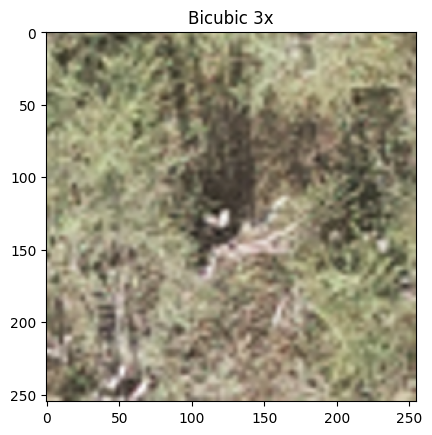

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.041280344..1.1559297].


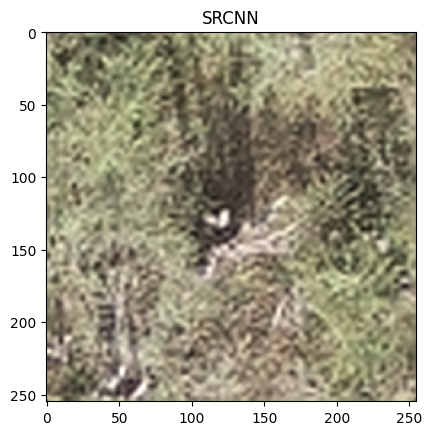

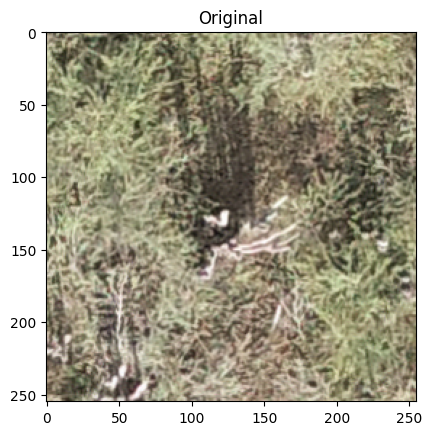

Loss: 0.0017084778170101344 | SRCNN PSNR: 27.8073755119977 | Bicubic PSNR: 26.94152636148516


In [ ]:
import random


def eval(model, test_set):
    total_loss = 0
    srcnn_psnr = 0
    bicubic_psnr = 0
    loss_function = torch.nn.MSELoss()

    with torch.no_grad():
        for idx, batch in enumerate(test_set):
            print(f"Batch: {idx+1} / {len(test_set)}", end="\r")
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            y_pred = model(features)

            plt.imshow(features[0].cpu().T)
            plt.title("Bicubic 3x")
            plt.show()
            plt.imshow(y_pred[0].cpu().T)
            plt.title("SRCNN")
            plt.show()
            plt.imshow(labels[0].cpu().T)
            plt.title("Original")
            plt.show()

            total_loss += loss_function(y_pred, labels).item()
            srcnn_psnr += psnr(y_pred, labels)
            bicubic_psnr += psnr(features, labels)
    print(f"Loss: {total_loss/len(test_set)} | SRCNN PSNR: {srcnn_psnr/len(test_set)} | Bicubic PSNR: {bicubic_psnr/len(test_set)}")

model = SRCNN()
model.load_state_dict(torch.load("trained_models/SRCNN_3000epochs_increasedlr.pt"))
model = model.to(device)
eval(model, test_dataloader)
